In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy
import os

%matplotlib inline

In [2]:
# check use gpu or cpu device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


Running on device: cuda:0


In [3]:
# initial model
mtcnn = MTCNN(keep_all=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


(401, 600, 3)


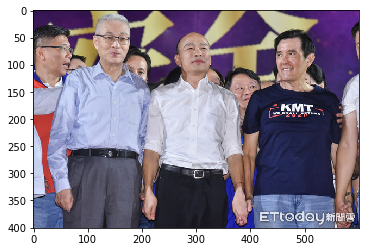

In [4]:
# read frame
frame = cv2.imread('./img/test/test1.jpg')

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

print(frame.shape)
plt.imshow(frame)

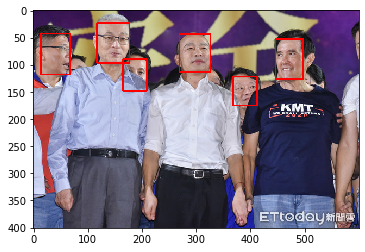

In [5]:
# detect faces
def detect(frame):
    boxes, probs = mtcnn.detect(frame)

    boxes = boxes.astype(int)
    
    return boxes

boxes = detect(frame)

# draw boxes
def draw_boxes(frame, boxes):
    frame = copy.deepcopy(frame)
    for box in boxes:
        (x1,y1,x2,y2) = box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)

    plt.imshow(frame)
    
draw_boxes(frame, boxes)

(160, 160, 3)


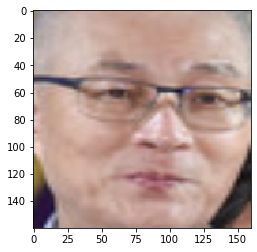

In [6]:
# extract face
def extract(frame, boxes):
    faces = []
    for box in boxes:
        (x1,y1,x2,y2) = box

        face = frame[y1:y2, x1:x2]

        face = cv2.resize(face, (160, 160))

        face = np.array(face)
        
        faces.append(face)
    
    return faces

faces = extract(frame, boxes)
print(faces[0].shape)
plt.imshow(faces[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


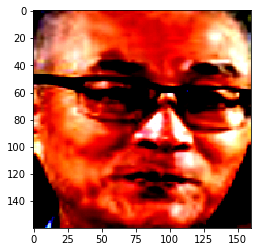

In [7]:
# pre_whiten
def pre_whiten(faces):
    axis = (1, 2, 3)
    size = faces[0].size

    mean = np.mean(faces, axis=axis, keepdims=True)
    std = np.std(faces, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0 / np.sqrt(size))
    faces = (faces - mean) / std_adj

    return faces

whiten_faces = pre_whiten(faces)
plt.imshow(whiten_faces[0])

In [8]:
# transform input shape and type
def transform_inp_faces(faces):
    
    faces = np.transpose(faces, (0,3,1,2))

    faces = torch.tensor(faces)
    
    faces = faces.type(torch.FloatTensor)
    
    faces = torch.stack(tuple(face for face in faces)).to(device)
    
    return faces

inp_faces = transform_inp_faces(whiten_faces)
print(inp_faces.shape)
print(inp_faces.type())

torch.Size([6, 3, 160, 160])
torch.cuda.FloatTensor


In [9]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    x = x.numpy()
    y = (x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon)))
    return torch.tensor(y)


In [10]:
# embedding
def embedding(faces):
    t = time.time()
    embeddings = resnet(faces).detach().cpu()
    t1 = time.time()
    print("embed time:",t1-t)
    embeddings = l2_normalize(embeddings)
    return embeddings

embeddings = embedding(inp_faces)
print(embeddings.shape)
print(embeddings)

embed time: 0.07301664352416992
torch.Size([6, 512])
tensor([[ 0.0548,  0.0084, -0.1021,  ..., -0.0593, -0.0687, -0.0926],
        [ 0.0464, -0.0344, -0.0234,  ...,  0.0415,  0.0139, -0.1297],
        [ 0.0058,  0.0061, -0.0466,  ..., -0.0916, -0.0714, -0.0281],
        [ 0.0500, -0.0304,  0.0229,  ..., -0.0405, -0.0318, -0.0244],
        [ 0.0081,  0.0294, -0.0424,  ..., -0.0704, -0.0435, -0.0342],
        [ 0.0483, -0.0128, -0.0432,  ..., -0.0194, -0.0448, -0.0786]])


./img/train/Angel/0.jpg
./img/train/DunYee/0.jpg
./img/train/Fish/0.jpg
./img/train/Kp/0.jpg
Angel


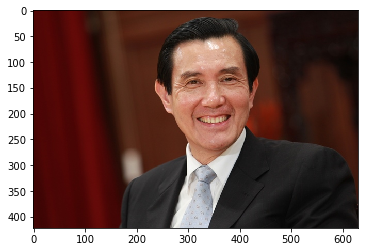

In [11]:
# build training dataset
train_imgs = []
train_names = []

dirs = os.listdir("./img/train/")

for name in dirs:
    img_path = "./img/train/" + name + '/0.jpg'
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    train_names.append(name)
    train_imgs.append(img)
    
print(train_names[0])
plt.imshow(train_imgs[0])

In [12]:
# build traing face dict
train_face_dict = {}

for name, img in zip(train_names,train_imgs):
    boxes = detect(img)
    faces = extract(img, boxes)
    white_faces = pre_whiten(faces)
    inp_faces = transform_inp_faces(white_faces)
    embeddings = embedding(inp_faces)
    train_face_dict[name] = embeddings[0]

embed time: 0.053011417388916016
embed time: 0.05301213264465332
embed time: 0.05401158332824707
embed time: 0.05401206016540527


embed time: 0.05501270294189453


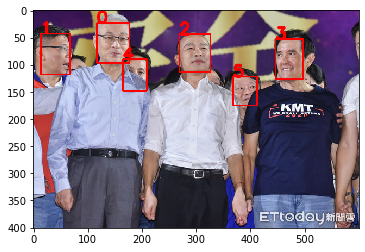

In [13]:
# build test face dict
def build_test_face_dict(frame):
    boxes = detect(frame)
    faces = extract(frame, boxes)
    white_faces = pre_whiten(faces)
    inp_faces = transform_inp_faces(white_faces)
    embeddings = embedding(inp_faces)
    names = [str(i) for i, _ in enumerate(boxes)]
    
    return names, embeddings, boxes

test_frame = cv2.imread('./img/test/test1.jpg')
test_frame = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
test_names, test_embeddings, test_boxes = build_test_face_dict(test_frame)
test_face_dict = zip(test_names, test_embeddings)

# draw boxes and names
def draw_boxes_names(frame,boxes,names):
    frame = copy.deepcopy(frame)
    for box, name in zip(boxes, names):
        (x1,y1,x2,y2) = box
        cv2.putText(frame, name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3, cv2.LINE_AA)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,0,0), 2)

    plt.imshow(frame)
    
draw_boxes_names(test_frame, test_boxes, test_names)

0
with Angel dist: 1.3477686643600464
with DunYee dist: 0.805447518825531
with Fish dist: 1.0080631971359253
with Kp dist: 1.3203887939453125


1
with Angel dist: 1.4103296995162964
with DunYee dist: 1.2419699430465698
with Fish dist: 1.203482747077942
with Kp dist: 1.2467294931411743


2
with Angel dist: 1.1560430526733398
with DunYee dist: 1.0177180767059326
with Fish dist: 0.6599159240722656
with Kp dist: 1.2759313583374023


3
with Angel dist: 0.7571868300437927
with DunYee dist: 1.2043136358261108
with Fish dist: 1.297966480255127
with Kp dist: 1.2407726049423218


4
with Angel dist: 1.3569937944412231
with DunYee dist: 1.254839539527893
with Fish dist: 0.9859573841094971
with Kp dist: 1.454628348350525


5
with Angel dist: 1.231909155845642
with DunYee dist: 1.1038014888763428
with Fish dist: 0.708801805973053
with Kp dist: 1.2290745973587036




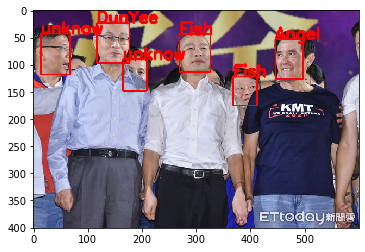

In [14]:
# recognize face
def recognize(train_face_dict, test_face_dict):
    recognize_names = []
    for test_name, test_emb in test_face_dict:
        print(test_name)
        min_dist = 0.9
        recognize_name = "unknow"

        for train_name,train_emb in train_face_dict.items():
            dist = (train_emb - test_emb).norm().item()
            print("with {} dist: {}".format(train_name, dist))
            if dist < min_dist:
                min_dist = dist
                recognize_name = train_name

        recognize_names.append(recognize_name)
        print("\n")
        
    return recognize_names

recognize_names = recognize(train_face_dict, test_face_dict)

# draw recognize result
draw_boxes_names(test_frame,test_boxes,recognize_names)

embed time: 0.0600132942199707


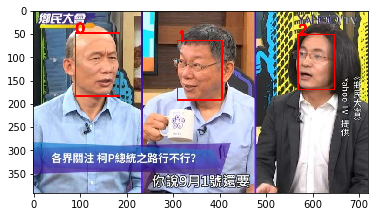

In [15]:
# test2
test_frame = cv2.imread('./img/test/test2.jpg')
test_frame = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
test_names, test_embeddings, test_boxes = build_test_face_dict(test_frame)
test_face_dict = zip(test_names, test_embeddings)
draw_boxes_names(test_frame, test_boxes, test_names)

0
with Angel dist: 1.0951558351516724
with DunYee dist: 1.0737181901931763
with Fish dist: 0.7895477414131165
with Kp dist: 0.9364671111106873


1
with Angel dist: 1.1792752742767334
with DunYee dist: 1.1291826963424683
with Fish dist: 1.1174298524856567
with Kp dist: 0.7186698317527771


2
with Angel dist: 1.174932599067688
with DunYee dist: 1.0238709449768066
with Fish dist: 1.0443440675735474
with Kp dist: 1.0907875299453735




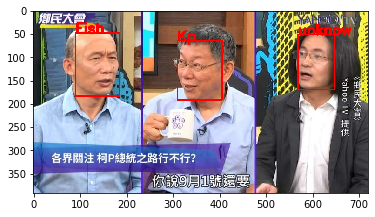

In [16]:
recognize_names = recognize(train_face_dict, test_face_dict)
draw_boxes_names(test_frame,test_boxes,recognize_names)